#### Refference :

https://www.tensorflow.org/text/tutorials/transformer

## Imports

In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 6.1 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 5.9 MB 51.5 MB/s 
     |████████████████████████████████| 438 kB 67.7 MB/s 
     |████████████████████████████████| 1.7 MB 55.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninsta

In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## Connect to Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Perpare the data

Download the dataset

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteWM7HJF/ted_hrlr_translate-train.tf…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteWM7HJF/ted_hrlr_translate-validati…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteWM7HJF/ted_hrlr_translate-test.tfr…

Dataset ted_hrlr_translate downloaded and prepared to ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [5]:
examples

{Split('train'): <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 Split('validation'): <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 Split('test'): <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>}

In [6]:
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path='~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0',
    file_format=tfrecord,
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
        'train': <SplitInfo num_examples=51785, num_shards=1>,
        'validation': <SplitInfo num_examples=1193, num_shards=1>,
    },
    

In [7]:
train_examples

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [8]:
val_examples

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [9]:
eng_examples = []
portugese_examples = []

for portugese_ex,eng_ex in train_examples.batch(3):
  eng_examples = eng_ex
  portugese_examples = portugese_ex
  
  print(f"Portuguese samples in a batch \n {portugese_ex}")
  
  print("\n\n")
  print(f"Enghlish samples in a batcb \n {eng_ex}")
  break



Portuguese samples in a batch 
 [b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
 b'mas e se estes fatores fossem ativos ?'
 b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .']



Enghlish samples in a batcb 
 [b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
 b'but what if it were active ?' b"but they did n't test for curiosity ."]


Set up the tokenizer

Tokenization is the process of breaking up a sentence into smaller meaningful entities for the model:

Here we use the bert tokenizer optimized for the current dataset 
BERT uses what is called a WordPiece tokenizer. It works by splitting words either into the full forms (e.g., one word becomes one token) or into word pieces — where one word can be broken into multiple tokens.


Ex : surfing = [surf,###ing]

Download and extract the model which will be used to tokenize

In [10]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [11]:
tokenizers = tf.saved_model.load(model_name)

In [12]:
dir(tokenizers)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_checkpoint_dependencies',
 '_deferred_dependencies',
 '_delete_tracking',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_export_to_saved_model_graph',
 '_gather_saveables_for_checkpoint',
 '_handle_deferred_dependencies',
 '_lookup_dependency',
 '_map_resources',
 '_maybe_initialize_trackable',
 '_name_based_attribute_restore',
 '_name_based_restores',
 '_no_dependency',
 '_object_identifier',
 '_preload_simple_restoration',
 '_restore_from_tensors',
 '_self_name_based_restores',
 '_self_saveable_object_factories',
 '_self_setattr_tracking',

In [13]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [14]:
eng_tokenizer = tokenizers.en.tokenize

In [15]:
prt_tokenizer = tokenizers.pt.tokenize

Visualizing the tokenizer

In [16]:
encoded_eng = eng_tokenizer(eng_examples)

In [17]:
encoded_eng

<tf.RaggedTensor [[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308,
  74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]               ,
 [2, 87, 90, 107, 76, 129, 1852, 30, 3],
 [2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]]>

the detokenize converts the padded token ids to their english readbale form

In [18]:
decoded_eng = tokenizers.en.detokenize(encoded_eng)

In [19]:
decoded_eng

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .',
       b'but what if it were active ?',
       b"but they did n ' t test for curiosity ."], dtype=object)>

In [20]:
print("Original sentences")
print(eng_examples)

Original sentences
tf.Tensor(
[b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
 b'but what if it were active ?' b"but they did n't test for curiosity ."], shape=(3,), dtype=string)


use of lookup : Converts token ids to token text

In [21]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded_eng)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

Finding the maximum number of tokens

In [22]:
lengths = []

for pt_ex,eng_ex in train_examples.batch(1024):
  
  pt_tokens = tokenizers.pt.tokenize(pt_ex) # this will return a list of list of token ids. we are passing 1024 pt data instances and each of which will result an individual list of token ids
  
  print(f"Type of the tokenizer  {type(pt_tokens)}")

  break

Type of the tokenizer  <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>


tensorflow ragged tensor : A RaggedTensor is a tensor with one or more ragged dimensions, which are dimensions whose slices may have different lengths. 

Dimensions 

In [23]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.en.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

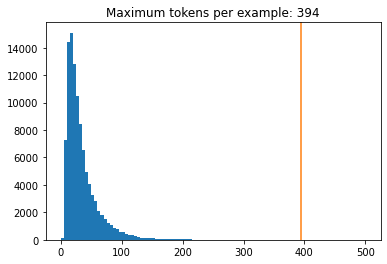

In [24]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))

plt.ylim(plt.ylim())

max_length = max(all_lengths)

plt.plot([max_length, max_length], plt.ylim())

plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline

1) It tokenizes each batch of text into ragged batches.

2) It trims each to be no longer than MAX_TOKENS

3) Splits the english tokens into inputs and labels.So that the label at each location is the id of the next token.

4) Converts the raggedTensor to padded dense tensor

5) Return an (inputs,labels) pair

In [25]:
MAX_TOKENS=128

def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [26]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [27]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))


In [28]:

# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [29]:
for (pt, en), en_labels in train_batches.take(1):
  print(pt.shape)
  print(en.shape)

(64, 65)
(64, 70)


### Defning the components of the main model

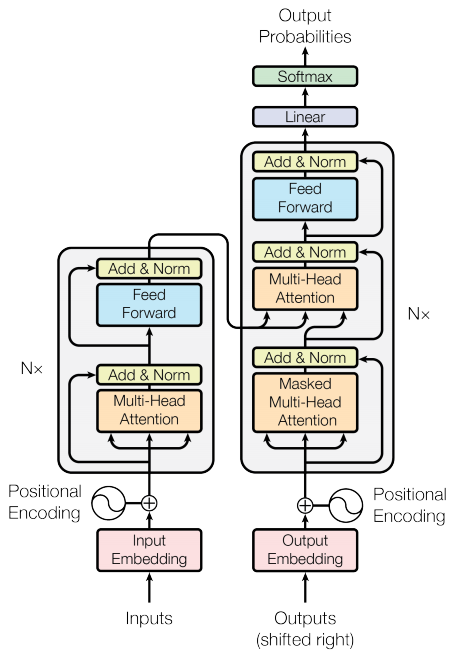

Define the Embedding and Positional encoding

In [30]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [31]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [32]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

Defning the feed forward network

In [33]:
def point_wise_feed_forward_network(
  d_model, # Input/output dimensionality.
  dff # Inner-layer dimensionality.
  ):

  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # Shape `(batch_size, seq_len, dff)`.
      tf.keras.layers.Dense(d_model)  # Shape `(batch_size, seq_len, d_model)`.
  ])

## Define the encoder layer

In [34]:
class EncoderLayer(tf.keras.layers.Layer):

  def __init__(self,*,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               dropout_rate=0.1
               ):
  
    super().__init__()


    # Multi-head self-attention.
  
    self.mha = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate,
        )
  
    # Point-wise feed-forward network.
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # Layer normalization.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for the point-wise feed-forward network.
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

  
  def call(self, x, training, mask):

    # A boolean mask.
  
    if mask is not None:
      mask1 = mask[:, :, None]
      mask2 = mask[:, None, :]
      attention_mask = mask1 & mask2
  
    else:
      attention_mask = None

    # Multi-head self-attention output (`tf.keras.layers.MultiHeadAttention `).
  
    attn_output = self.mha(
        query=x,  # Query Q tensor.
        value=x,  # Value V tensor.
        key=x,  # Key K tensor.
        attention_mask=attention_mask, # A boolean mask that prevents attention to certain positions.
        training=training, # A boolean indicating whether the layer should behave in training mode.
        )

    # Multi-head self-attention output after layer normalization and a residual/skip connection.
    out1 = self.layernorm1(x + attn_output)  # Shape `(batch_size, input_seq_len, d_model)`

    # Point-wise feed-forward network output.
    ffn_output = self.ffn(out1)  # Shape `(batch_size, input_seq_len, d_model)`
    ffn_output = self.dropout1(ffn_output, training=training)
  
    # Point-wise feed-forward network output after layer normalization and a residual skip connection.
    out2 = self.layernorm2(out1 + ffn_output)  # Shape `(batch_size, input_seq_len, d_model)`.

    return out2

Define the encoder

In [35]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,
               *,
               num_layers,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input (Portuguese) vocabulary size.
               dropout_rate=0.1
               ):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # Embeddings + Positional encoding
    self.pos_embedding = PositionalEmbedding(input_vocab_size, d_model)

    # Encoder layers.
    self.enc_layers = [
        EncoderLayer(
          d_model=d_model,
          num_attention_heads=num_attention_heads,
          dff=dff,
          dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    # Dropout.
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  # Masking.
  def compute_mask(self, x, previous_mask=None):
    return self.pos_embedding.compute_mask(x, previous_mask)

  def call(self, x, training):

    seq_len = tf.shape(x)[1]

    # Sum up embeddings and positional encoding.
    mask = self.compute_mask(x)
    x = self.pos_embedding(x)  # Shape `(batch_size, input_seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x, training=training)

    # N encoder layers.
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # Shape `(batch_size, input_seq_len, d_model)`.

### Define the decoder layer

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               dropout_rate=0.1
               ):
    super().__init__()

    # Masked multi-head self-attention.
    self.mha_masked = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate
    )
    # Multi-head cross-attention.
    self.mha_cross = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate
    )

    # Point-wise feed-forward network.
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # Layer normalization.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for the point-wise feed-forward network.
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, mask, enc_output, enc_mask, training):
    # The encoder output shape is `(batch_size, input_seq_len, d_model)`.

    # A boolean mask.
    self_attention_mask = None
    if mask is not None:
      mask1 = mask[:, :, None]
      mask2 = mask[:, None, :]
      self_attention_mask = mask1 & mask2

    # Masked multi-head self-attention output (`tf.keras.layers.MultiHeadAttention`).
    attn_masked, attn_weights_masked = self.mha_masked(
        query=x,
        value=x,
        key=x,
        attention_mask=self_attention_mask,  # A boolean mask that prevents attention to certain positions.
        use_causal_mask=True,  # A boolean to indicate whether to apply a causal mask to prevent tokens from attending to future tokens.
        return_attention_scores=True,  # Shape `(batch_size, target_seq_len, d_model)`.
        training=training  # A boolean indicating whether the layer should behave in training mode.
        )

    # Masked multi-head self-attention output after layer normalization and a residual/skip connection.
    out1 = self.layernorm1(attn_masked + x)

    # A boolean mask.
    attention_mask = None
    if mask is not None and enc_mask is not None:
      mask1 = mask[:, :, None]
      mask2 = enc_mask[:, None, :]
      attention_mask = mask1 & mask2

    # Multi-head cross-attention output (`tf.keras.layers.MultiHeadAttention `).
    attn_cross, attn_weights_cross = self.mha_cross(
        query=out1,
        value=enc_output,
        key=enc_output,
        attention_mask=attention_mask,  # A boolean mask that prevents attention to certain positions.
        return_attention_scores=True,  # Shape `(batch_size, target_seq_len, d_model)`.
        training=training  # A boolean indicating whether the layer should behave in training mode.
    )

    # Multi-head cross-attention output after layer normalization and a residual/skip connection.
    out2 = self.layernorm2(attn_cross + out1)  # (batch_size, target_seq_len, d_model)

    # Point-wise feed-forward network output.
    ffn_output = self.ffn(out2)  # Shape `(batch_size, target_seq_len, d_model)`.
    ffn_output = self.dropout1(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # Shape `(batch_size, target_seq_len, d_model)`.

    return out3, attn_weights_masked, attn_weights_cross

## Define the decoder

In [37]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,
               *,
               num_layers,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               target_vocab_size,
               dropout_rate=0.1
               ):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(target_vocab_size, d_model)

    self.dec_layers = [
        DecoderLayer(
          d_model=d_model,
          num_attention_heads=num_attention_heads,
          dff=dff,
          dropout_rate=dropout_rate)
        for _ in range(num_layers)
    ]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, enc_output, enc_mask, training):
    attention_weights = {}

    mask = self.pos_embedding.compute_mask(x)
    x = self.pos_embedding(x)  # Shape: `(batch_size, target_seq_len, d_model)`.

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2  = self.dec_layers[i](x, mask, enc_output, enc_mask, training)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # The shape of x is `(batch_size, target_seq_len, d_model)`.
    return x, attention_weights

Setting up the Transformer

In [38]:
class Transformer(tf.keras.Model):
  def __init__(self,
               *,
               num_layers, # Number of decoder layers.
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input (Portuguese) vocabulary size.
               target_vocab_size, # Target (English) vocabulary size.
               dropout_rate=0.1
               ):
    super().__init__()
    # The encoder.
    self.encoder = Encoder(
      num_layers=num_layers,
      d_model=d_model,
      num_attention_heads=num_attention_heads,
      dff=dff,
      input_vocab_size=input_vocab_size,
      dropout_rate=dropout_rate
      )

    # The decoder.
    self.decoder = Decoder(
      num_layers=num_layers,
      d_model=d_model,
      num_attention_heads=num_attention_heads,
      dff=dff,
      target_vocab_size=target_vocab_size,
      dropout_rate=dropout_rate
      )

    # The final linear layer.
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument.
    # Portuguese is used as the input (`inp`) language.
    # English is the target (`tar`) language.
    inp, tar = inputs

    # The encoder output.
    enc_output = self.encoder(inp, training)  # `(batch_size, inp_seq_len, d_model)`
    enc_mask = self.encoder.compute_mask(inp)

    # The decoder output.
    dec_output, attention_weights = self.decoder(
        tar, enc_output, enc_mask, training)  # `(batch_size, tar_seq_len, d_model)`

    # The final linear layer output.
    final_output = self.final_layer(dec_output)  # Shape `(batch_size, tar_seq_len, target_vocab_size)`.

    # Return the final output and the attention weights.
    return final_output, attention_weights

Set hyper pramaeters

In [39]:
num_layers = 4
d_model = 128
dff = 512
num_attention_heads = 8
dropout_rate = 0.1

## Training

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [41]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

## Define the loss function

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [43]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [44]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

### instantiate the transformer model

In [45]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_attention_heads=num_attention_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

#### Checkpointing

In [46]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

## Traning the transformer

In [47]:
train_step_signature = [
    (
         tf.TensorSpec(shape=(None, None), dtype=tf.int64),
         tf.TensorSpec(shape=(None, None), dtype=tf.int64)),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# The `@tf.function` trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

@tf.function(input_signature=train_step_signature)
def train_step(inputs, labels):
  (inp, tar_inp) = inputs
  tar_real = labels

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Defining the epochs

In [48]:
EPOCHS = 10

In [49]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8829 Accuracy 0.0007
Epoch 1 Batch 50 Loss 8.8027 Accuracy 0.0083
Epoch 1 Batch 100 Loss 8.6848 Accuracy 0.0334
Epoch 1 Batch 150 Loss 8.5645 Accuracy 0.0469
Epoch 1 Batch 200 Loss 8.4172 Accuracy 0.0564
Epoch 1 Batch 250 Loss 8.2381 Accuracy 0.0631
Epoch 1 Batch 300 Loss 8.0438 Accuracy 0.0673
Epoch 1 Batch 350 Loss 7.8462 Accuracy 0.0709
Epoch 1 Batch 400 Loss 7.6600 Accuracy 0.0749
Epoch 1 Batch 450 Loss 7.4905 Accuracy 0.0835
Epoch 1 Batch 500 Loss 7.3379 Accuracy 0.0927
Epoch 1 Batch 550 Loss 7.1971 Accuracy 0.1013
Epoch 1 Batch 600 Loss 7.0666 Accuracy 0.1088
Epoch 1 Batch 650 Loss 6.9440 Accuracy 0.1161
Epoch 1 Batch 700 Loss 6.8290 Accuracy 0.1232
Epoch 1 Batch 750 Loss 6.7219 Accuracy 0.1303
Epoch 1 Batch 800 Loss 6.6227 Accuracy 0.1372
Epoch 1 Loss 6.6061 Accuracy 0.1383
Time taken for 1 epoch: 193.02 secs

Epoch 2 Batch 0 Loss 4.9746 Accuracy 0.2491
Epoch 2 Batch 50 Loss 5.0311 Accuracy 0.2498
Epoch 2 Batch 100 Loss 4.9794 Accuracy 0.2552
Epoch 2 Batch

### Run inference

In [50]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # Therefore, recalculate them outside the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [51]:
translator = Translator(tokenizers, transformer)

In [52]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')


In [53]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [54]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .
